# Growing Neural Cellular Automata [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/40_growing_nca.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import jax
import jax.numpy as jnp
import mediapy
import optax
import PIL
from flax import nnx
from tqdm.auto import tqdm

from cax.core import CA
from cax.core.perceive import ConvPerceive, grad_kernel, identity_kernel
from cax.core.update import NCAUpdate
from cax.nn.pool import Pool
from cax.utils import clip_and_uint8, get_emoji, rgba_to_rgb

## Configuration

In [3]:
seed = 0

channel_size = 16
num_kernels = 3
hidden_size = 128
cell_dropout_rate = 0.5

pool_size = 1_024
batch_size = 8
num_steps = 128
learning_rate = 2e-3

emoji = "🦎"
size = 40
pad_width = 16

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

""

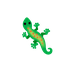

In [4]:
def get_y_from_emoji(emoji: str) -> jax.Array:
	"""Get target y from an emoji."""
	emoji_pil = get_emoji(emoji)
	emoji_pil = emoji_pil.resize((size, size), resample=PIL.Image.Resampling.LANCZOS)

	y = jnp.array(emoji_pil, dtype=jnp.float32) / 255.0
	y = jnp.pad(y, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)))

	return y


y = get_y_from_emoji(emoji)

mediapy.show_image(y)

## Instantiate system

In [ ]:
perceive = ConvPerceive(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	rngs=rngs,
	feature_group_count=channel_size,
)
update = NCAUpdate(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
	zeros_init=True,
)

In [6]:
class GrowingNCA(CA):
	"""Growing Neural Cellular Automata."""

	def __init__(self, perceive, update):
		"""Initialize Growing NCA."""
		super().__init__(perceive, update)

		# Initialize kernel with sobel filters
		kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
		kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
		self.perceive.conv.kernel = nnx.Param(kernel)

	@nnx.jit
	def render(self, state):
		"""Render state to RGB."""
		rgba = state[..., -4:]
		rgb = rgba_to_rgb(rgba)

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgb)

	@nnx.jit
	def render_rgba(self, state):
		"""Render state to RGBA."""
		rgba = state[..., -4:]

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgba)

In [7]:
ca = GrowingNCA(perceive, update)

In [8]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", sum(x.size for x in jax.tree.leaves(params)))

Number of params: 8768


## Sample initial state

In [9]:
def sample_state():
	"""Sample a state with a single alive cell."""
	spatial_dims = y.shape[:2]

	# Init state
	state = jnp.zeros(spatial_dims + (channel_size,))

	# Set the center cell to alive
	mid = tuple(size // 2 for size in spatial_dims)
	return state.at[mid[0], mid[1], -1].set(1.0)

## Train

### Pool

In [10]:
state = jax.vmap(lambda _: sample_state())(jnp.zeros(pool_size))

pool = Pool.create({"state": state})

### Optimizer

In [11]:
lr_sched = optax.linear_schedule(
	init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000
)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [12]:
def mse(state):
	"""Mean Squared Error."""
	return jnp.mean(jnp.square(state[..., -4:] - y))

In [13]:
@nnx.jit
def loss_fn(ca, state, key):
	"""Loss function."""
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	_, state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps),
			in_axes=(state_axes, 0),
		)
	)(ca, state)

	# Sample a random step
	idx = jax.random.randint(key, (batch_size,), num_steps // 2, num_steps)
	state = state[jnp.arange(batch_size), idx]

	loss = mse(state)
	return loss, state

### Train step

In [14]:
@nnx.jit
def train_step(ca, optimizer, pool, key):
	"""Train step."""
	sample_key, loss_key = jax.random.split(key)

	# Sample from pool
	pool_idx, batch = pool.sample(sample_key, batch_size=batch_size)
	current_state = batch["state"]

	# Sort by descending loss
	sort_idx = jnp.argsort(jax.vmap(mse)(current_state), descending=True)
	pool_idx = pool_idx[sort_idx]
	current_state = current_state[sort_idx]

	# Sample a new state to replace the worst
	new_state = sample_state()
	current_state = current_state.at[0].set(new_state)

	(loss, current_state), grad = nnx.value_and_grad(
		loss_fn, has_aux=True, argnums=nnx.DiffState(0, update_params)
	)(ca, current_state, loss_key)
	optimizer.update(grad)

	pool = pool.update(pool_idx, {"state": current_state})
	return loss, pool

### Main loop

In [19]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []
for i in pbar:
	key, subkey = jax.random.split(key)
	loss, pool = train_step(ca, optimizer, pool, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.3e}"})

## Run

In [20]:
num_examples = 8

state_init = jax.vmap(lambda _: sample_state())(jnp.zeros(num_examples))

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state_final, states = nnx.split_rngs(splits=num_examples)(
	nnx.vmap(
		lambda ca, state_init: ca(state_init, num_steps=2 * num_steps),
		in_axes=(state_axes, 0),
	)
)(ca, state_init)

## Visualize

,,,,,,,

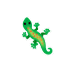
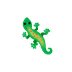
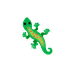
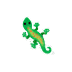
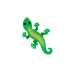
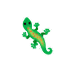
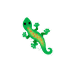
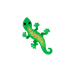

,,,,,,,

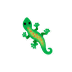
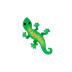
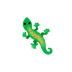
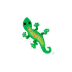
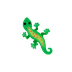
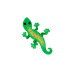
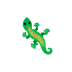
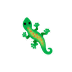

In [21]:
frames_final = nnx.vmap(
	lambda ca, state: ca.render(state),
	in_axes=(None, 0),
)(ca, state_final)

frames_final_rgba = nnx.vmap(
	lambda ca, state: ca.render_rgba(state),
	in_axes=(None, 0),
)(ca, state_final)

mediapy.show_images(frames_final, width=128, height=128)
mediapy.show_images(frames_final_rgba, width=128, height=128)

,,,,,,,

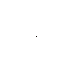
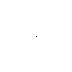
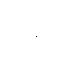
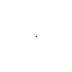
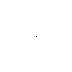
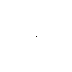
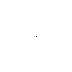
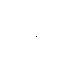

In [25]:
states = jnp.concatenate([state_init[:, None], states], axis=1)
frames = nnx.vmap(
	lambda ca, state: ca.render(state),
	in_axes=(None, 0),
)(ca, states)

mediapy.show_videos(frames, width=128, height=128, codec="gif")